# Mosquito Classification Tutorial

This tutorial demonstrates how to use CulicidaeLab for mosquito species classification. We'll cover:

1. Setting up the classification model
2. Loading and preprocessing images
3. Running classification
4. Interpreting results

First, let's import the necessary libraries:

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from culicidaelab import MosquitoClassifier
from culicidaelab.core.settings import get_settings
from culicidaelab.core.provider_service import ProviderService
from culicidaelab.predictors.model_weights_manager import ModelWeightsManager
from pathlib import Path

c:\Users\lenova\CascadeProjects\culicidaelab\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Initialize Settings and Classifier

First, we'll initialize our settings and create a MosquitoClassifier instance. The settings module will handle downloading model weights if they're not already present:

In [2]:
# Get settings instance
settings = get_settings()
settings.list_model_types()

['classifier', 'detector', 'segmenter']

In [3]:
classifier_conf = settings.get_config("predictors.classifier")
print(classifier_conf.model_arch)

tiny_vit_21m_224.in1k


In [4]:
classifier_conf.model_dump()

{'target_': 'culicidaelab.predictors.Classifier',
 'model_path': 'weights/classification/culico-net-cls-v1-17.pkl',
 'confidence': 0.5,
 'device': 'cpu',
 'params': {'input_size': 224,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225]},
 'repository_id': 'iloncka/culico-net-cls-v1',
 'filename': 'culico-net-cls-v1-17.pkl',
 'predict_batch_size': 4,
 'model_arch': 'tiny_vit_21m_224.in1k',
 'dataset_repository': 'iloncka/mosquito-species-classification-dataset',
 'visualization': {'font_scale': 0.5,
  'text_color': '#000000',
  'text_thickness': 2,
  'format': 'png',
  'dpi': 300}}

In [5]:
print(classifier_conf.repository_id)
print(classifier_conf.filename)

iloncka/culico-net-cls-v1
culico-net-cls-v1-17.pkl


In [6]:
# Get model path and config
model_path = settings.get_model_weights_path("classifier")
model_config = settings.get_config("predictors.classifier").model_dump()
print(f"Using model path: {model_path}")
print(f"Using model config: {model_config}")

Using model path: C:\Users\lenova\AppData\Local\culicidaelab\culicidaelab\models\weights\classification\culico-net-cls-v1-17.pkl
Using model config: {'target_': 'culicidaelab.predictors.Classifier', 'model_path': 'weights/classification/culico-net-cls-v1-17.pkl', 'confidence': 0.5, 'device': 'cpu', 'params': {'input_size': 224, 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}, 'repository_id': 'iloncka/culico-net-cls-v1', 'filename': 'culico-net-cls-v1-17.pkl', 'predict_batch_size': 4, 'model_arch': 'tiny_vit_21m_224.in1k', 'dataset_repository': 'iloncka/mosquito-species-classification-dataset', 'visualization': {'font_scale': 0.5, 'text_color': '#000000', 'text_thickness': 2, 'format': 'png', 'dpi': 300}}


In [ ]:
provider_service = ProviderService(settings=settings)
weights_manager = ModelWeightsManager(settings=settings, provider_service=provider_service)

classifier = MosquitoClassifier(settings, weights_manager=weights_manager, load_model=True)

Weights file found at: C:\Users\lenova\AppData\Local\culicidaelab\culicidaelab\models\blobs\1719be673435fa3b1c753f648c6e40b8014d48574b621719d56333066c9e2891


In [13]:
classes_sp = classifier.learner.dls.vocab

In [15]:
species_map = {i: s for i, s in enumerate(classes_sp)}
print(species_map)

{0: 'aedes_aegypti', 1: 'aedes_albopictus', 2: 'aedes_canadensis', 3: 'aedes_dorsalis', 4: 'aedes_geniculatus', 5: 'aedes_koreicus', 6: 'aedes_triseriatus', 7: 'aedes_vexans', 8: 'anopheles_arabiensis', 9: 'anopheles_freeborni', 10: 'anopheles_sinensis', 11: 'class_background', 12: 'culex_inatomii', 13: 'culex_pipiens', 14: 'culex_quinquefasciatus', 15: 'culex_tritaeniorhynchus', 16: 'culiseta_annulata', 17: 'culiseta_longiareolata'}


## 2. Load and Preprocess Image

Now let's load a test image. We'll use one of the sample images provided in the test_data directory:

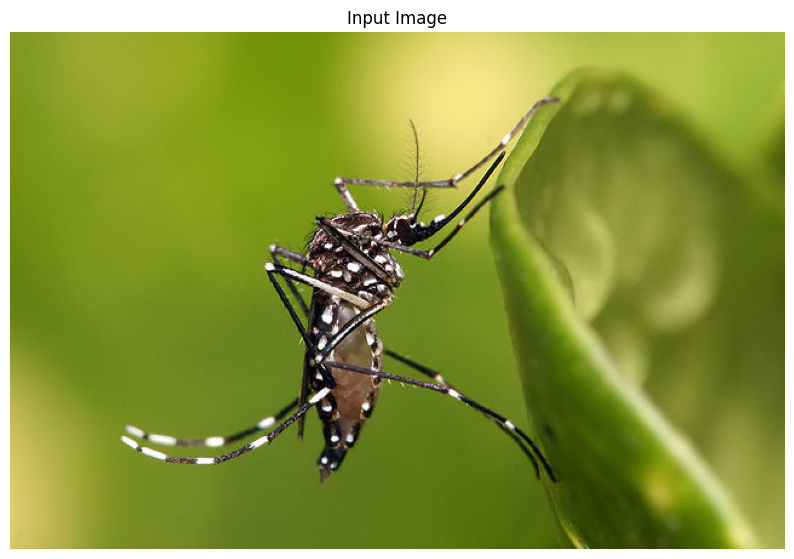

In [8]:
# Find test image path
image_path = Path("test_img") / "640px-Aedes_aegypti.jpg"

# Load and preprocess image
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Could not load image from {image_path}")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()

## 3. Run Classification

Let's classify the mosquito species. The classifier will return probabilities for each species class:

In [9]:
# Run classification
predictions = classifier.predict(image)

# Get species names and probabilities from predictions
species_names = [p[0] for p in predictions]  # First element of each tuple is species name
probabilities = [p[1] for p in predictions]  # Second element is the confidence score

# Sort predictions by probability
sorted_indices = np.argsort(probabilities)[::-1]
sorted_species = [species_names[i] for i in sorted_indices]
sorted_probs = [probabilities[i] for i in sorted_indices]

# Print top predictions based on config
top_k = model_config["params"].get("top_k", 3)
conf_threshold = model_config["params"].get("conf_threshold", 0.5)

print(f"\nTop {top_k} predictions (confidence threshold: {conf_threshold:.0%}):")
for species, prob in zip(sorted_species[:top_k], sorted_probs[:top_k]):
    if prob >= conf_threshold:
        print(f"{species}: {prob:.1%}")
    else:
        print(f"{species}: {prob:.1%} (below threshold)")


Top 3 predictions (confidence threshold: 50%):
Background: 100.0%
Aedes geniculatus: 0.0% (below threshold)
Aedes canadensis: 0.0% (below threshold)


## 4. Visualize Results

Let's create a bar plot of the classification probabilities:

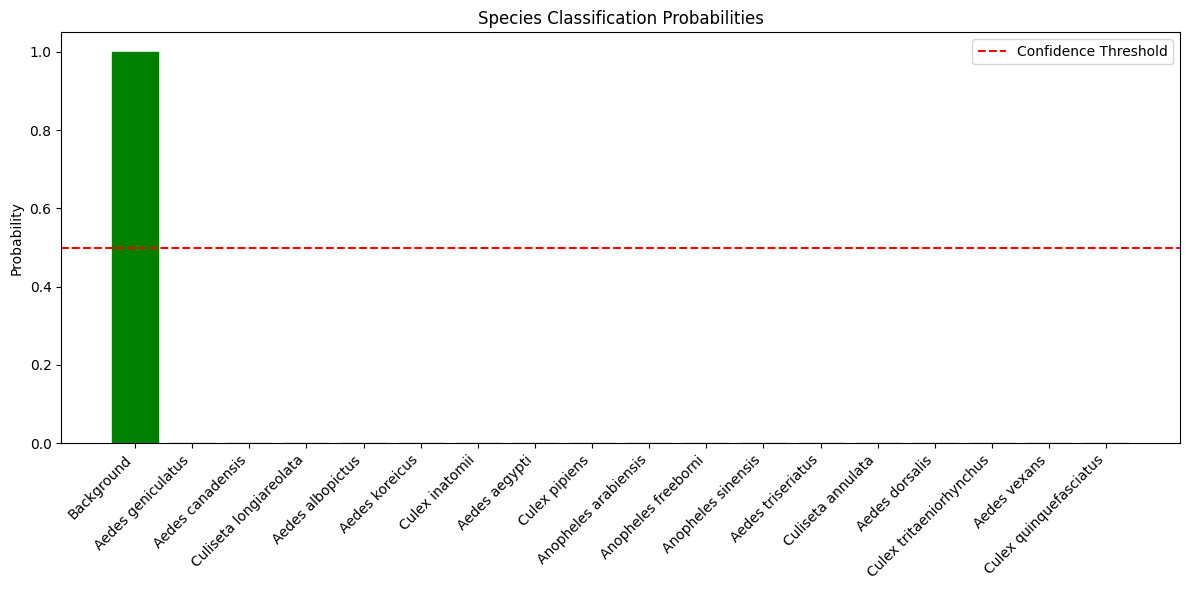

In [10]:
# Plot probabilities
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_species, sorted_probs)

# Color bars based on confidence threshold
for i, prob in enumerate(sorted_probs):
    bars[i].set_color("green" if prob >= conf_threshold else "gray")

plt.axhline(y=conf_threshold, color="r", linestyle="--", label="Confidence Threshold")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Probability")
plt.title("Species Classification Probabilities")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
annotated_image = classifier.visualize(
    image,
    predictions,
    save_path="annotated_image.jpg",
)

plt.figure(figsize=(15, 5))
plt.imshow(annotated_image)
plt.axis("off")
plt.title("Top 5 predictions")

UnboundLocalError: cannot access local variable 'b' where it is not associated with a value

In [ ]:
metrics = classifier.evaluate("Aedes albopictus", input_data=image)
print(metrics)

{'accuracy': 0.0, 'confidence': 0.9999974966049194, 'top_1_correct': 0.0, 'top_5_correct': 1.0}


In [ ]:
metrics = classifier.evaluate("Aedes albopictus", predictions)
print(metrics)

{'accuracy': 0.0, 'confidence': 0.9999974966049194, 'top_1_correct': 0.0, 'top_5_correct': 1.0}


In [ ]:
image_path2 = str(Path("test_img") / "640px-Aedes_aegypti2.jpg")
image2 = cv2.imread(image_path2)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

batch = [
    image,
    image2,
    image,
    image2,
    image,
    image2,
    image,
    image2,
    image,
    image2,
    image,
    image2,
]

classifier_batch_result = classifier.predict_batch(batch)
print(classifier_batch_result)

Predicting batch (classifier):   0%|          | 0/12 [00:00<?, ?it/s]

Predicting batch (classifier):   8%|▊         | 1/12 [00:01<00:14,  1.34s/it]

Predicting batch (classifier):  17%|█▋        | 2/12 [00:02<00:13,  1.31s/it]

Predicting batch (classifier):  25%|██▌       | 3/12 [00:03<00:11,  1.23s/it]

Predicting batch (classifier):  33%|███▎      | 4/12 [00:04<00:09,  1.22s/it]

Predicting batch (classifier):  42%|████▏     | 5/12 [00:06<00:08,  1.18s/it]

Predicting batch (classifier):  50%|█████     | 6/12 [00:07<00:07,  1.22s/it]

Predicting batch (classifier):  58%|█████▊    | 7/12 [00:08<00:06,  1.25s/it]

Predicting batch (classifier):  67%|██████▋   | 8/12 [00:09<00:04,  1.24s/it]

Predicting batch (classifier):  75%|███████▌  | 9/12 [00:11<00:03,  1.22s/it]

Predicting batch (classifier):  83%|████████▎ | 10/12 [00:12<00:02,  1.20s/it]

Predicting batch (classifier):  92%|█████████▏| 11/12 [00:13<00:01,  1.26s/it]

Predicting batch (classifier): 100%|██████████| 12/12 [00:14<00:00,  1.23s/it]

[[('Background', 0.9999974966049194), ('Aedes geniculatus', 1.3878860727345455e-06), ('Aedes canadensis', 6.275938062572095e-07), ('Culiseta longiareolata', 1.9189951672160532e-07), ('Aedes albopictus', 1.5878956105552788e-07), ('Aedes koreicus', 6.77346392308209e-08), ('Culex inatomii', 6.519470474586342e-08), ('Aedes aegypti', 1.0762919444573527e-08), ('Culex pipiens', 6.705281663244023e-09), ('Anopheles arabiensis', 4.4237538077140925e-09), ('Anopheles freeborni', 1.9299242204340317e-09), ('Anopheles sinensis', 1.881420796934208e-09), ('Aedes triseriatus', 1.7156526199713085e-09), ('Culiseta annulata', 6.858243417617871e-10), ('Aedes dorsalis', 6.465855073578552e-10), ('Culex tritaeniorhynchus', 3.611400900549455e-10), ('Aedes vexans', 1.790639858612053e-10), ('Culex quinquefasciatus', 1.7036581867468925e-10)], [('Background', 0.9999974966049194), ('Aedes geniculatus', 1.3878860727345455e-06), ('Aedes canadensis', 6.275938062572095e-07), ('Culiseta longiareolata', 1.9189951672160532